In [1]:
from src.libs import *
from src.helper_functions import *
from src.model_manager import *
from jupyter_bbox_widget import BBoxWidget


# fill memory bank

In [3]:
# build model

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_manager = ModelManager(device=device)
model_manager.load_dinov2_model(dinov2_model_name='dinov2_vitl14')
model_manager.load_sam2_model(sam2_model_type='tiny', points_per_side=32)
print('Done!')

Using cache found in C:\Users\ADMIN/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\ADMIN/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\ADMIN/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\ADMIN/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Done!


In [2]:
# load image
img_path = r'assets\2762.jpg'
img = Image.open(img_path).convert('RGB')
ori_w, ori_h = img.size

widget = BBoxWidget()
widget.image = encode_image(img_path)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [4]:
boxes = widget.bboxes
ref_boxes = []
for box in boxes:
    x1, y1, x2, y2 = box['x'], box['y'], box['x'] + box['width'], box['y'] + box['height']
    ref_boxes.append([x1, y1, x2, y2])


print('len(ref_boxes): ', len(ref_boxes))
input_box = np.array(ref_boxes)

len(ref_boxes):  1


In [5]:
device = model_manager.device
ref_masks = []
reference_data = {}
if len(ref_boxes) > 0:
    with torch.inference_mode(), torch.autocast(device, dtype=torch.bfloat16):
        model_manager.sam2_predictor.set_image(img)
        masks, scores, _ = model_manager.sam2_predictor.predict(
            point_coords=None,
            point_labels=None,
            box=input_box[None, :],
            multimask_output=False,
        )

    ref_masks = masks[:, 0] if len(ref_boxes) > 1 else masks

    cls_nm = 'filled'

    reference_data = {
        cls_nm: [
            {
                'img_path': img_path,
                'masks': ref_masks
            }
        ]
    }

memory_bank = build_memory_bank(reference_data=reference_data, dinov2_model=model_manager.dinov2_model, dinov2_transform=model_manager.dinov2_transform, device=device)
torch.cuda.empty_cache()

Building Memory Bank...


100%|██████████| 1/1 [00:00<00:00,  7.81it/s]

Memory Bank Built.


# visualize support masks

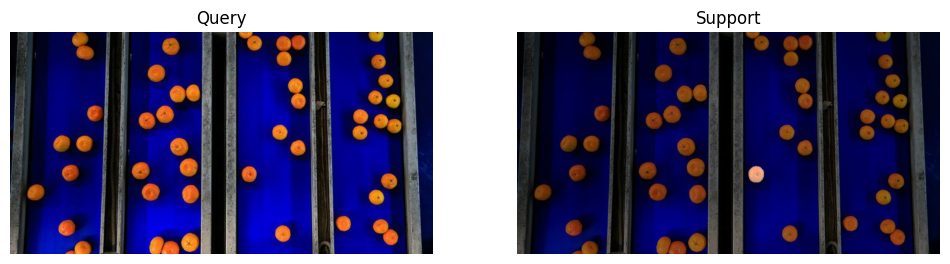

In [6]:
n_cols = 1 + len(ref_boxes)

fig, axes = plt.subplots(1, n_cols, figsize=(12, 12))
axes[0].imshow(img)
axes[0].set_title('Query')
axes[0].axis('off')

for i in range(n_cols - 1):
    axes[i + 1].imshow(img)
    axes[i + 1].imshow(ref_masks[i], cmap='gray', alpha=0.4) 
    axes[i + 1].set_title('Support')
    axes[i + 1].axis('off')

# Predict

In [10]:
img_pil, masks, final_segmented_instances = predict_single_image(
    img_path=img_path, 
    memory_bank=memory_bank,
    sam2_mask_generator=model_manager.sam2_mask_generator,
    dinov2_model=model_manager.dinov2_model,
    dinov2_transform=model_manager.dinov2_transform,
    min_aera=0.0,
    max_area=None,
    iou_threshold=0.25,
    conf_threshold=0.5,
    device=model_manager.device
)
torch.cuda.empty_cache()

# Automatic mask generation

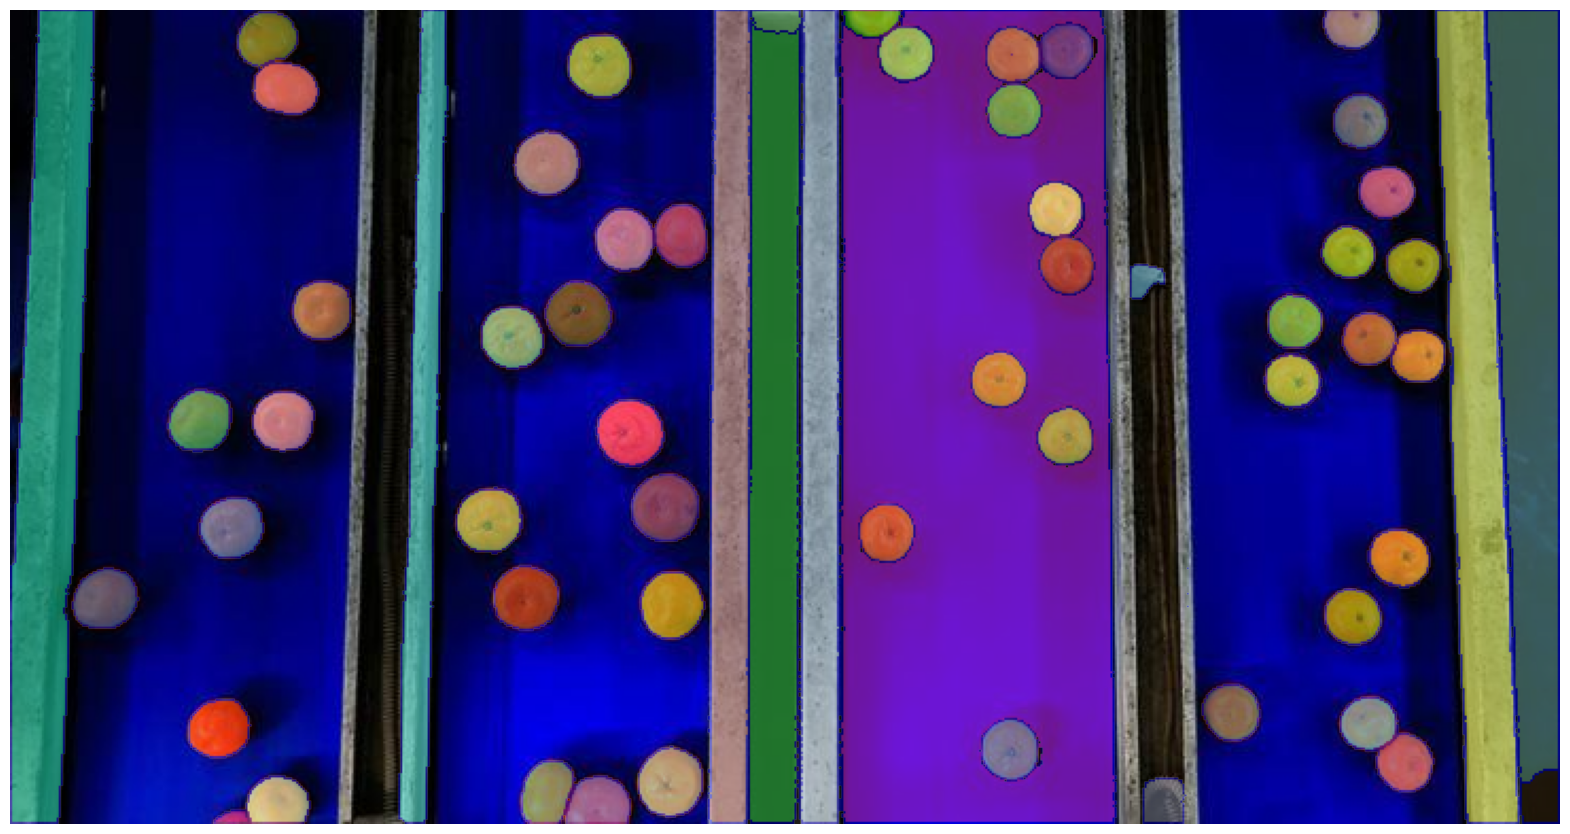

In [11]:
plt.figure(figsize=(20, 20))
plt.imshow(img_pil)
show_anns(masks)
plt.axis('off')
plt.show()

# Result

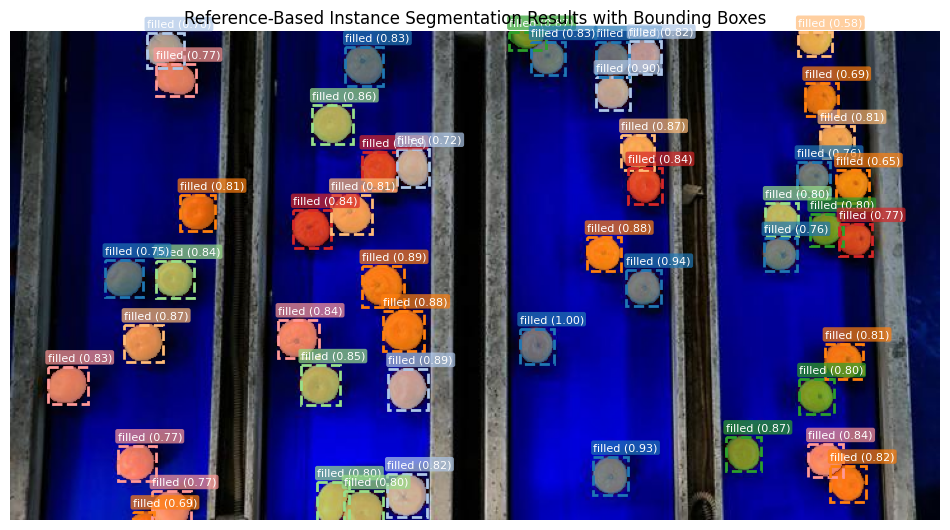

In [12]:
visualize_results(img_path, final_segmented_instances)